In [0]:
%matplotlib inline
import collections
import pandas as pd
import sklearn
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Embedding, Bidirectional, Dropout
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
!pip install fasttext
!pip install pythainlp
!pip install attacut

from attacut import tokenize
from pythainlp import word_tokenize
import fasttext

     |████████████████████████████████| 71kB 5.1MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3021453 sha256=4dc2bc57116cea5670f7d00eec6362bc8938667ca34c6119804cc21e1bff0ce9
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext
     |████████████████████████████████| 11.1MB 7.2MB/s 
     |████████████████████████████████| 1.4MB 52.3MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp36-none-any.whl size=1434677 sha256=a9f451451de28b12dd6b6943a6f8d642b3d2afadad72f55566664ca8c53a18a6
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
     |████████████████████████████████| 1.3MB 9.2MB/s 
     |████████████████████████████████| 276kB 53.2MB/s 
     |████████████████████████

In [3]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP/full_datasets.csv')
# Show the top 5 rows
display(data.head())
# Summarize the data
data.describe()

,text,intent
0,เกาะติดเศรษฐกิจการเงินน้ำมันแพงเกี่ยวข้องกับค่า,น้ำมัน
1,มิยคนไทยซดน้ำมันแพงวเศษรับไม่ต่ำกว่า30บลิตร,น้ำมัน
2,ต่างชาติถล่มขายหุ้นเครือปตทมาร์เก็ตแคปพคหายแสน...,น้ำมัน
3,คาดโอเปคไม่ผลิตเพิ่มหวั่นน้ำมันราคาพุ่งยันปริม...,น้ำมัน
4,สศกคาดผลไม้ปี49ล้านตลาดพิษน้ำมันส่งผลกำลังซื้อ...,น้ำมัน


,text,intent
count,991587,991587
unique,987350,9
top,7elevenพวกเรามั่นใจเพราะเหตุผลเพียงไม่กี่ประการ,ธนาคาร
freq,6,267349


In [4]:
data.intent.unique()

array(['น้ำมัน', 'พลังงานไฟฟ้า', 'การบิน', 'อสังหา', 'ธุรกิจค้าปลีก',
       'ธนาคาร', 'ภัยพิบัติ', 'สงคราม', 'โรคระบาด'], dtype=object)

In [5]:
intent_mapping = {'น้ำมัน' : 0, 'พลังงานไฟฟ้า' : 1, 'การบิน' : 2, 'อสังหา' : 3, 'ธุรกิจค้าปลีก' : 4,
                  'ธนาคาร' : 5, 'ภัยพิบัติ' : 6, 'สงคราม' : 7, 'โรคระบาด' : 8}
data.intent = data.intent.map(intent_mapping)
data.head()

,text,intent
0,เกาะติดเศรษฐกิจการเงินน้ำมันแพงเกี่ยวข้องกับค่า,0
1,มิยคนไทยซดน้ำมันแพงวเศษรับไม่ต่ำกว่า30บลิตร,0
2,ต่างชาติถล่มขายหุ้นเครือปตทมาร์เก็ตแคปพคหายแสน...,0
3,คาดโอเปคไม่ผลิตเพิ่มหวั่นน้ำมันราคาพุ่งยันปริม...,0
4,สศกคาดผลไม้ปี49ล้านตลาดพิษน้ำมันส่งผลกำลังซื้อ...,0


In [6]:
train_data, test_data = train_test_split( data, test_size=0.2,random_state=42)

X_train = train_data.text.values
X_test = test_data.text.values

y_train = train_data.intent.values
y_test = test_data.intent.values

num_classes = 9
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (793269,)
X_test shape: (198318,)
y_train shape: (793269, 9)
y_test shape: (198318, 9)


In [7]:
def tokenizers(sentense):
    words = []
    for w in sentense :
        word_token = word_tokenize(w , engine = 'attacut')
        words.append(word_token)
    
    return words

token = tokenizers(X_train)
token[:5]

[['เศรษฐศาสตร์',
  'เพื่อ',
  'ชีวิต',
  'ทาง',
  'ออก',
  'พลังงาน',
  'ไทย',
  'ต้อง',
  'เป็น',
  'ไท'],
 ['บังคับ', 'คดี', 'จับมือ', 'แบงก์', 'ขาย', 'ทอดตลาด'],
 ['คูเนีย',
  'แปลง',
  'ร่าง',
  'พร้อม',
  'รุก',
  'หนัก',
  'ตลาด',
  'ไทย',
  'ซุ่ม',
  'คุย',
  'ซี',
  'ไอ',
  'เอ็มบี',
  'เปิด'],
 ['วัดปรอท2', 'ปีสุวรรณภูมิเสรีรัตน์', 'สาง', 'ปัญหา', 'สาน', 'ฝัน'],
 ['รอบ', 'โลกวัน', 'นี้', 'โบอิ้ง', 'ยัน', '737', 'แม็กซ์', 'ปลอด', 'ภัย']]

In [8]:
word = []
for sen in token:
  word += sen
  
word_count = list()
#use set and len to get the number of unique words
word_count.extend(collections.Counter(word).most_common(len(set(word))))
#include a token for unknown word
word_count.append(("UNK",0))
dictionary = dict()
dictionary["for_keras_zero_padding"] = 0
for word in word_count:
  dictionary[word[0]] = len(dictionary)
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

print(len(dictionary))
print("output sample (dictionary):",{k: dictionary[k] for k in list(dictionary)[:10]})
print("output sample (reverse dictionary):",{k: reverse_dictionary[k] for k in list(reverse_dictionary)[:10]})

430394
output sample (dictionary): {'for_keras_zero_padding': 0, 'ข่าว': 1, 'เงิน': 2, 'การ': 3, 'ปี': 4, 'โลก': 5, 'ไม่': 6, 'ไทย': 7, 'ทุน': 8, 'ที่': 9}
output sample (reverse dictionary): {0: 'for_keras_zero_padding', 1: 'ข่าว', 2: 'เงิน', 3: 'การ', 4: 'ปี', 5: 'โลก', 6: 'ไม่', 7: 'ไทย', 8: 'ทุน', 9: 'ที่'}


In [0]:
pre_embed = []
for sen in token:
  pre_embed += sen
  pre_embed.append('\n')

with open('data.txt', mode='w', encoding='utf-8') as file:
    file.write(' '.join(pre_embed))

word2vec = fasttext.train_unsupervised('data.txt', epoch=10, ws=3, dim=100)

In [0]:
test_token = tokenizers(X_test)

In [0]:
def word_vec(list_data):
    keys = dict.keys(dictionary)
    for data in list_data:
        for word in range(len(data)):
            if data[word] in keys:
                data[word] = dictionary[data[word]]
            else:
                data[word] = dictionary['UNK']
    return list_data

X_train = word_vec(token)
X_test = word_vec(test_token)

maxlen = 21
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [12]:
print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (793269, 21)
x_test shape: (198318, 21)
y_train shape: (793269, 9)
y_test shape: (198318, 9)


In [13]:
word_num = len(list(reverse_dictionary.values()))
embedding_matrix = []

for i in range(word_num):
  if i != (word_num-1):
    embedding_matrix.append(word2vec.get_sentence_vector(reverse_dictionary[i+1]))
  else:
    embedding_matrix.append(np.zeros(100,))

embedding_matrix = np.array(embedding_matrix)
print(embedding_matrix.shape)

(430394, 100)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 100)           43039400  
_________________________________________________________________
bidirectional (Bidirectional (None, 21, 128)           84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 21, 128)           98816     
_________________________________________________________________
flatten (Flatten)            (None, 2688)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               688384    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 2

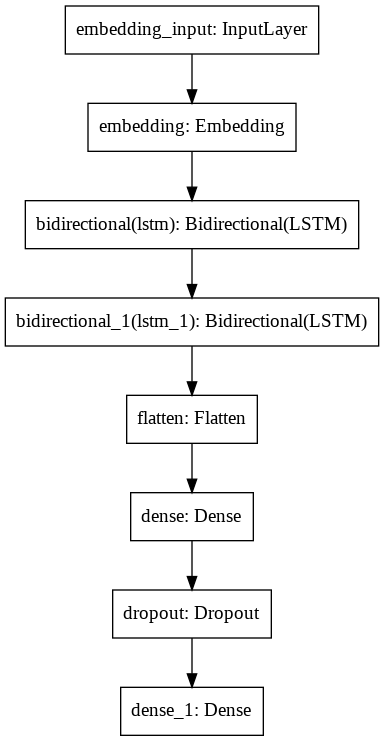

In [14]:
model = Sequential()
model.add(Embedding(len(dictionary), 100, weights = [embedding_matrix], input_length = maxlen ))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.33))
model.add(Dense(9, activation='softmax'))

model.summary()
plot_model(model)

In [15]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.fit(X_train, y_train, epochs=5, verbose=1, validation_data = (X_test, y_test), batch_size=128)

Epoch 1/5
6198/6198 [==============================] - 2329s 376ms/step - loss: 0.7510 - acc: 0.7591 - val_loss: 0.6342 - val_acc: 0.7964
Epoch 2/5
6198/6198 [==============================] - 2316s 374ms/step - loss: 0.4040 - acc: 0.8760 - val_loss: 0.6588 - val_acc: 0.7999
Epoch 3/5
6198/6198 [==============================] - 2326s 375ms/step - loss: 0.2625 - acc: 0.9177 - val_loss: 0.7082 - val_acc: 0.7976
Epoch 4/5
6198/6198 [==============================] - 2317s 374ms/step - loss: 0.2231 - acc: 0.9276 - val_loss: 0.8414 - val_acc: 0.7958
Epoch 5/5
6198/6198 [==============================] - 2312s 373ms/step - loss: 0.2003 - acc: 0.9338 - val_loss: 0.8606 - val_acc: 0.7917


In [16]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
1550/1550 [==============================] - 8s 5ms/step - loss: 0.8606 - acc: 0.7917
test loss, test acc: [0.8606162071228027, 0.7917032241821289]


In [17]:
preds =  np.argmax(model.predict(X_test), axis=-1) 
preds

array([5, 5, 5, ..., 3, 6, 7])

In [21]:
classes = ['น้ำมัน', 'พลังงานไฟฟ้า', 'การบิน', 'อสังหา', 'ธุรกิจค้าปลีก',
           'ธนาคาร', 'ภัยพิบัติ', 'สงคราม', 'โรคระบาด']

report = classification_report(test_data.intent.values, preds, target_names=classes)
print(report)

               precision    recall  f1-score   support

       น้ำมัน       0.81      0.71      0.76     23148
 พลังงานไฟฟ้า       0.69      0.68      0.68     12164
       การบิน       0.71      0.77      0.74     17315
       อสังหา       0.82      0.75      0.79     34981
ธุรกิจค้าปลีก       0.73      0.74      0.74     19764
       ธนาคาร       0.81      0.85      0.83     53456
    ภัยพิบัติ       0.78      0.83      0.81     11812
       สงคราม       0.85      0.88      0.87     20483
     โรคระบาด       0.89      0.88      0.88      5195

     accuracy                           0.79    198318
    macro avg       0.79      0.79      0.79    198318
 weighted avg       0.79      0.79      0.79    198318

